# Task # 1 - Introduction to Observational Seismology in Python

Welcome to the first laboratory task of observational seismology. In this set of laboratories, we will learn the skills of modern observational seismology via the Python/Obspy workflow. Today, you will implement a basic seismological workflow; downloading, selecting, processing and plotting seismic waveforms. We will be skipping over some parts of the scientific python ecosystem in favor of jumping right into the seismology - these will be saved for the second lab session. 

## Downloading

In [19]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
client = Client("IRIS")
st = UTCDateTime(2004,12,26,0,0,0)
seismograms = client.get_waveforms(network = "IU", 
                                   station = "*", 
                                   location = "", 
                                   channel = "BHZ", 
                                   starttime = st, 
                                   endtime = st+6*60*60)

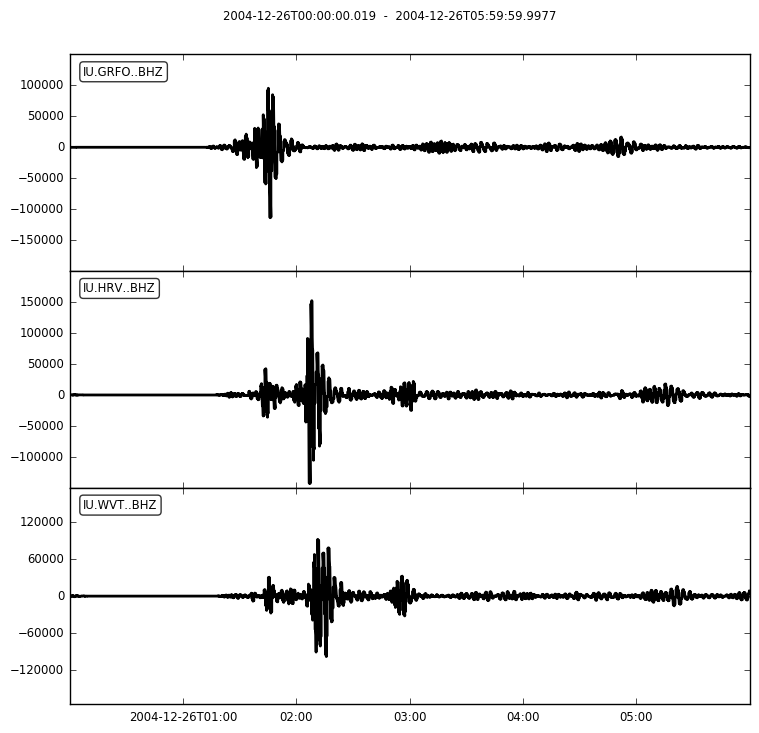

In [25]:
seismograms.copy().filter('bandpass', freqmin=0.005, freqmax=0.01).plot()